# Importation

In [1]:
import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

In [2]:
import gc ,random 
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
from sklearn import model_selection

import cv2
import SimpleITK as sitk
from ipywidgets import interact, fixed
from tqdm import tqdm 
import matplotlib.pyplot as plt
from PIL import Image


import torch
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
from transformers import get_linear_schedule_with_warmup
import albumentations as A 

from collections import OrderedDict
from sklearn.model_selection import train_test_split

from loss import * 
from models import *
from datasets.merging_dataset import * 
from models.casceded_models_rec import * 

device = torch.device('cuda')

In [3]:
# SEED Everything 

SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

# Utils

In [4]:
data = pd.read_csv('data_5fold.csv')
subjects = data[data['slice']==0]

In [5]:
def loss_fn (img1, img2):
    return 1-SSIM()(img1, img2)

In [6]:
def eval_fn(subject_df_dataset, model, simple=True):
    
      
    data_loader = torch.utils.data.DataLoader(
                subject_df_dataset,
                batch_size=8,
                num_workers=4)
    
    model.eval()
    tr_loss = 0
    counter = 0
    
    tk0 = enumerate(data_loader)

    with torch.no_grad():
        
        for bi, d in tk0 : 
            
            y = d["HR"]  #shape = (batch_size, 160, 160)
            y = y.to(device, dtype=torch.float)
            x = d["LR"]
            x = x.to(device, dtype=torch.float)
            x = x.unsqueeze(1)
            y_hat = model(x) #forward prop
            y = y.unsqueeze(1)
            
            if simple==False : 
                y_hat = y_hat[:,0,:,:].unsqueeze(1)
            
            loss = loss_fn(y_hat, y) # Loss calaculation of batch i 
        

            tr_loss += loss.item()
            counter +=1 

            
        return 1 - tr_loss/counter 

In [7]:
def bar_plot_ssim(df, Left = True ) : 
    
    results = np.zeros((6,5))
    
    if Left : 
        a = 'Left'
    else :
        a = 'Right'
        
    for f in tqdm(range(5)) : 
        
        PATH_UNet = f'trained_model/UNet_reconstruction/Unet Left fold {f}.pt'
        PATH_GAN = f'trained_model/GAN_reconstruction/GAN Left fold {f}.pt'
        PATH_CUNet = f'trained_model/Casceded UNet/Rec Cascaded Unet V2 Left fold {f}.pt'
        PATH_PCUNet = f'trained_model/PCasceded UNet/Rec PCascaded Unet V2 Left fold {f}.pt'
        PATH_GANCUNet = f'trained_model/Casceded UNet/GAN Rec Cascaded Unet V2 Left fold {f}.pt'
        PATH_GANPCUNet = f'trained_model/PCasceded UNet/GAN Rec PCascaded Unet V2 Left fold {f}.pt'
        
        
        subject_df = df[df['kfold']==f]
        subject_df_dataset = Merging_data_set(subject_df, subjects, Left = True, is_train = False)
        
        
        model = UNet(1,1)
        model = model.to(device) 
        model.load_state_dict(torch.load(PATH_UNet))
        score = eval_fn(subject_df_dataset,model) 
        results[0,f] = score


        model = UNet(1,1)
        model = model.to(device) 
        model.load_state_dict(torch.load(PATH_GAN))
        score = eval_fn(subject_df_dataset,model) 
        results[1,f] = score
    

        model = CascadedUNet()
        model = model.to(device) 
        model.load_state_dict(torch.load(PATH_CUNet))
        score = eval_fn(subject_df_dataset,model, False) 
        results[2,f] = score
    

        model = ParallelCascadedUNet()
        model = model.to(device) 
        model.load_state_dict(torch.load(PATH_PCUNet))
        score = eval_fn(subject_df_dataset,model, False) 
        results[3,f] = score
        
         
        model = GANCascadedUNet()
        model = model.to(device)
        model.load_state_dict(torch.load(PATH_GANCUNet))
        score = eval_fn(subject_df_dataset,model,device)    
        results[4,f] = score
        
        model = GANParallelCascadedUNet()
        model = model.to(device)
        model.load_state_dict(torch.load(PATH_GANPCUNet))
        score = eval_fn(subject_df_dataset,model,device) 
        
        results[5,f] = score        
        
    models = ['UNet', 'GAN', 'CUNet', 'PCUNet', 'GANCUNet', 'GANPCUNet']
    
    data_results = None
    for num , m in enumerate(models) : 
        
        temp= pd.DataFrame()
        temp['model'] = [m] * 5 
        temp['ssim_score'] = results[num,:]
        data_results = pd.concat([data_results,temp], axis = 0)

    return data_results
    


In [8]:
def loss_psnr (img1, img2):
    return PSNR()(img1, img2)

In [9]:
def eval_psnr(subject_df_dataset, model, simple=True):
    
      
    data_loader = torch.utils.data.DataLoader(
                subject_df_dataset,
                batch_size=8,
                num_workers=4)
    
    model.eval()
    tr_loss = 0
    counter = 0
    
    tk0 = enumerate(data_loader)

    with torch.no_grad():
        
        for bi, d in tk0 : 
            
            y = d["HR"]  #shape = (batch_size, 160, 160)
            y = y.to(device, dtype=torch.float)
            x = d["LR"]
            x = x.to(device, dtype=torch.float)
            x = x.unsqueeze(1)
            y_hat = model(x) #forward prop
            y = y.unsqueeze(1)
            
            if simple==False : 
                y_hat = y_hat[:,0,:,:].unsqueeze(1)
            
            loss = loss_psnr(y_hat, y) # Loss calaculation of batch i 
        

            tr_loss += loss.item()
            counter +=1 

            
        return tr_loss/counter 

In [10]:
def bar_plot_psnr(df, Left = True ) : 
    
    results = np.zeros((6,5))
    
    if Left : 
        a = 'Left'
    else :
        a = 'Right'
        
    for f in tqdm(range(5)) : 
        
        PATH_UNet = f'trained_model/UNet_reconstruction/Unet Left fold {f}.pt'
        PATH_GAN = f'trained_model/GAN_reconstruction/GAN Left fold {f}.pt'
        PATH_CUNet = f'trained_model/Casceded UNet/Rec Cascaded Unet V2 Left fold {f}.pt'
        PATH_PCUNet = f'trained_model/PCasceded UNet/Rec PCascaded Unet V2 Left fold {f}.pt'
        PATH_GANCUNet = f'trained_model/Casceded UNet/GAN Rec Cascaded Unet V2 Left fold {f}.pt'
        PATH_GANPCUNet = f'trained_model/PCasceded UNet/GAN Rec PCascaded Unet V2 Left fold {f}.pt'
        
        
        subject_df = df[df['kfold']==f]
        subject_df_dataset = Merging_data_set(subject_df, subjects, Left = True, is_train = False)
        
        
        model = UNet(1,1)
        model = model.to(device) 
        model.load_state_dict(torch.load(PATH_UNet))
        score = eval_psnr(subject_df_dataset,model) 
        results[0,f] = score


        model = UNet(1,1)
        model = model.to(device) 
        model.load_state_dict(torch.load(PATH_GAN))
        score = eval_psnr(subject_df_dataset,model) 
        results[1,f] = score
    

        model = CascadedUNet()
        model = model.to(device) 
        model.load_state_dict(torch.load(PATH_CUNet))
        score = eval_psnr(subject_df_dataset,model, False) 
        results[2,f] = score
    

        model = ParallelCascadedUNet()
        model = model.to(device) 
        model.load_state_dict(torch.load(PATH_PCUNet))
        score = eval_psnr(subject_df_dataset,model, False) 
        results[3,f] = score
        
         
        model = GANCascadedUNet()
        model = model.to(device)
        model.load_state_dict(torch.load(PATH_GANCUNet))
        score = eval_psnr(subject_df_dataset,model,device)    
        results[4,f] = score
        
        model = GANParallelCascadedUNet()
        model = model.to(device)
        model.load_state_dict(torch.load(PATH_GANPCUNet))
        score = eval_psnr(subject_df_dataset,model,device) 
        
        results[5,f] = score        
        
    models = ['UNet', 'GAN', 'CUNet', 'PCUNet', 'GANCUNet', 'GANPCUNet']
    
    data_results = None
    for num , m in enumerate(models) : 
        
        temp= pd.DataFrame()
        temp['model'] = [m] * 5 
        temp['ssim_score'] = results[num,:]
        data_results = pd.concat([data_results,temp], axis = 0)

    return data_results
    


# Models Evaluation 

## SSIM : Structural Similarity

In [11]:
results_fin = bar_plot_ssim(data)

100%|██████████| 5/5 [05:50<00:00, 70.03s/it]


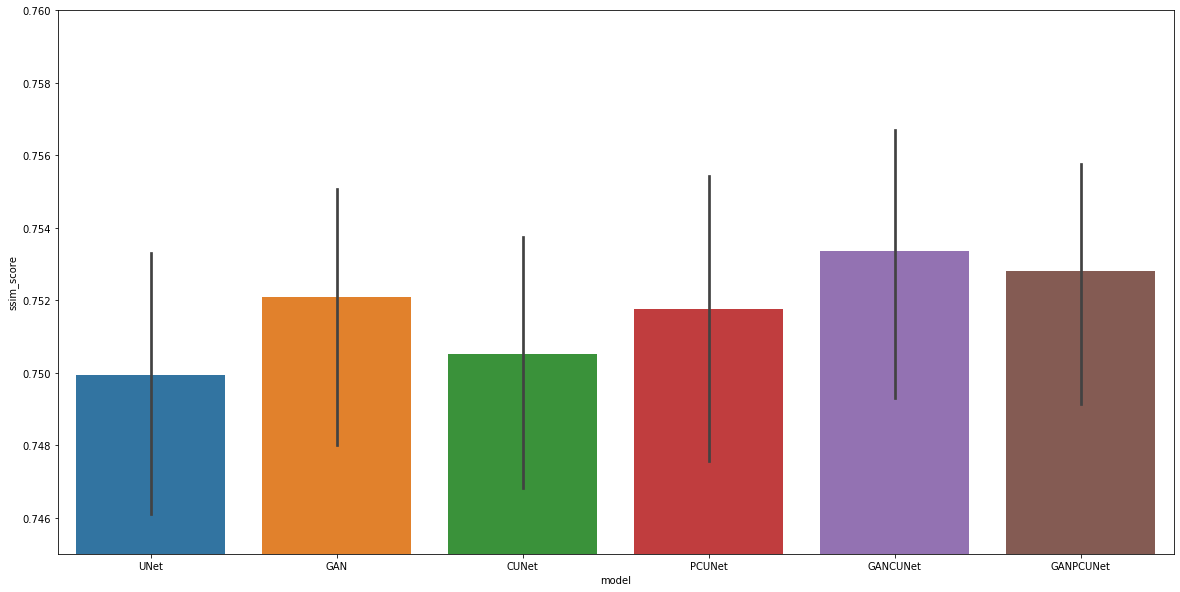

In [12]:
plt.figure(figsize=(20,10))
ax = sns.barplot( x = 'model', y="ssim_score", data=results_fin)
ax.set_ylim(0.745,0.76)
plt.show()

## PSNR : Peak Signal to Noise Ratio

In [13]:
results = bar_plot_psnr(data)

100%|██████████| 5/5 [05:08<00:00, 61.61s/it]


(24, 25.5)

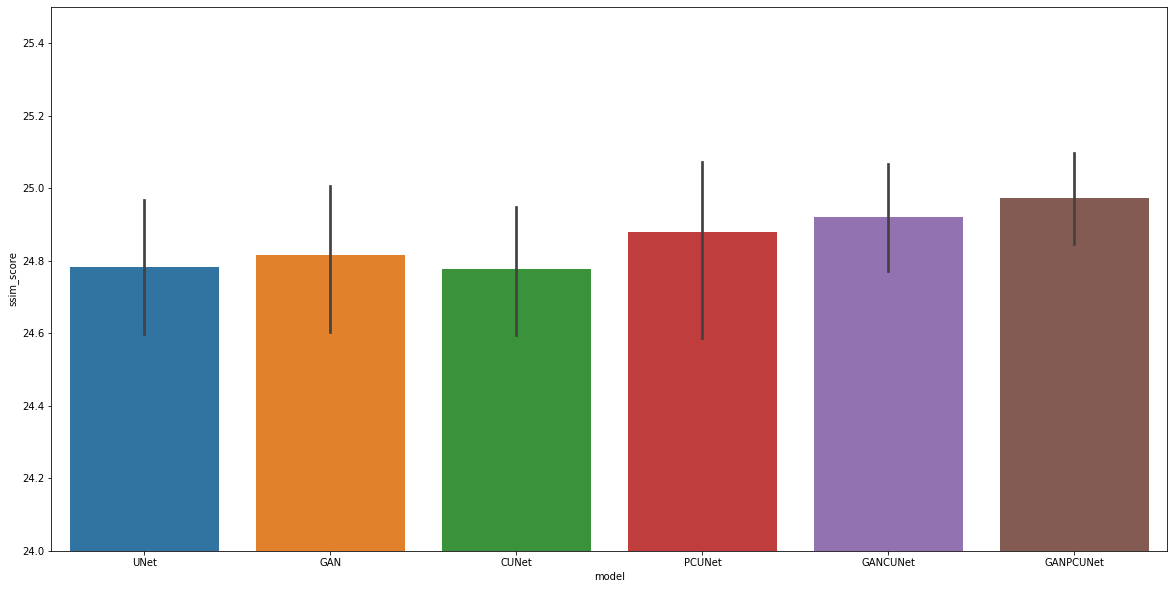

In [14]:
plt.figure(figsize=(20,10))
ax = sns.barplot( x = 'model', y="ssim_score", data=results)
ax.set_ylim(24,25.5)